In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from discretization import *
from utils import *
from models.dynamic import DynamicSuperresModel
from models.fourier import Fourier1DModel, FourierNDModel

In [2]:
def inverse_mu_grid(theta, points):
    if theta[1] > 0:
        points /= np.sum(theta)
    else:
        points = (points - (theta[1],0)) / (theta[0]-theta[1])
        
    rotinv45 = np.array([[1, -1], [1, 1]])
    return points@rotinv45.transpose()

In [3]:
disc3rad100 = Discretization(
    tau = 1,
    K = 1,
    num_dirs = 30,
    num_rads = 100,
    num_extra_ns = 0,
    grid_size_nu = 100,
    grid_size_mu = 100,
    adaptive_grids=True
)
disc = disc3rad100
mu_grids = disc.adapted_mu_grids()
nu_grids = disc.adapted_nu_grids()

In [4]:
mu_radon_mats = np.empty((disc.num_dirs, disc.num_total_ns), dtype=object)
for di in range(disc.num_dirs):
    print("Building mu radon mats: {}/{}".format(di+1, disc.num_dirs))
    mu_radon_mats[di] = build_radon_matrix(disc.mu_grids[di], disc.ns, disc.rads[di])

# build matrices for line projections of nu
# for each n in ns, nu(n, .) is projected onto the direction of each d in dirs
nu_radon_mats = np.empty((disc.num_total_ns, disc.num_dirs), dtype=object)
if disc.num_dirs > 0:
    for ni, n in enumerate(disc.ns):
        print("Building nu radon mats: {}/{}".format(ni+1, disc.num_total_ns))
        nu_radon_mats[ni] = build_radon_matrix(disc.nu_grids[ni], disc.dirs, disc.rads[:,ni])

Building mu radon mats: 1/30
Building mu radon mats: 2/30
Building mu radon mats: 3/30
Building mu radon mats: 4/30
Building mu radon mats: 5/30
Building mu radon mats: 6/30
Building mu radon mats: 7/30
Building mu radon mats: 8/30
Building mu radon mats: 9/30
Building mu radon mats: 10/30
Building mu radon mats: 11/30
Building mu radon mats: 12/30
Building mu radon mats: 13/30
Building mu radon mats: 14/30
Building mu radon mats: 15/30
Building mu radon mats: 16/30
Building mu radon mats: 17/30
Building mu radon mats: 18/30
Building mu radon mats: 19/30
Building mu radon mats: 20/30
Building mu radon mats: 21/30
Building mu radon mats: 22/30
Building mu radon mats: 23/30
Building mu radon mats: 24/30
Building mu radon mats: 25/30
Building mu radon mats: 26/30
Building mu radon mats: 27/30
Building mu radon mats: 28/30
Building mu radon mats: 29/30
Building mu radon mats: 30/30
Building nu radon mats: 1/3
Building nu radon mats: 2/3
Building nu radon mats: 3/3


In [5]:
std_grid1 = np.linspace(0, 1, disc.grid_size_mu)
ones_mu = np.array([
    np.eye(1,disc.gs_mu_sq,i)
    for i in range(disc.gs_mu_sq)
]).reshape(disc.grid_size_mu,disc.grid_size_mu,-1)
gi_mu = RegularGridInterpolator([std_grid1, std_grid1], ones_mu)

In [6]:
folder = "data/gt_4-20parts_uniformsep/sep0-0.1/"
i = 194
_, actual_sources, weights = np.load("{}gt_{}.npy".format(folder,i), allow_pickle=True)

In [19]:
#actual_sources = np.array([[0.5, 0.5, 0, 0]])
#actual_sources = np.array([[0.5, 0.5, 0, 0],
#                          [0.7, 0.7, 0, 0.2]])
#weights = 10*np.ones_like(weights)

In [20]:
mu = np.empty((disc.num_dirs, disc.grid_size_mu, disc.grid_size_mu))
nu = np.empty((disc.num_total_ns, disc.grid_size_nu, disc.grid_size_nu))
for di, theta in enumerate(disc.dirs):
    jrads = np.vstack((actual_sources[:,:2]@theta,actual_sources[:,2:]@theta)).transpose()
    invpts = inverse_mu_grid(theta, jrads)
    interp = gi_mu(invpts)
    mu[di] = (weights@interp).reshape(disc.grid_size_mu, disc.grid_size_mu)

for ni, n in enumerate(disc.ns):
    nu_grid1 = disc.adapted_nu_grid_1d(n)
    ones_nu = np.array([
        np.eye(1,disc.gs_nu_sq,i)
        for i in range(disc.gs_nu_sq)
    ]).reshape(disc.grid_size_nu,disc.grid_size_nu,-1)
    gi_nu = RegularGridInterpolator([nu_grid1, nu_grid1], ones_nu)
    qprojs = n[0]*actual_sources[:,:2]+n[1]*actual_sources[:,2:]
    ninterp = gi_nu(qprojs)
    del gi_nu
    nu[ni] = (weights@ninterp).reshape(disc.grid_size_nu, disc.grid_size_nu)

In [75]:
di = 14
ni = 2
plt.figure()
plt.plot(disc.rads[di,ni], mu_radon_mats[di,ni]@mu[di].flatten(), label="mu")
plt.figure()
plt.plot(disc.rads[di,ni], nu_radon_mats[ni, di]@nu[ni].flatten(), label="nu")
plt.figure()
plt.plot(disc.rads[di,ni], mu_radon_mats[di,ni]@mu[di].flatten()-nu_radon_mats[ni, di]@nu[ni].flatten(), label="nu")
plt.legend()
plt.show()

In [21]:
di = 6
theta = disc.dirs[di]
ni = 1
n = disc.ns[ni]
print("n", n)
jrads = np.vstack((actual_sources[:,:2]@theta,actual_sources[:,2:]@theta)).transpose()
print(jrads)
qprojs = n[0]*actual_sources[:,:2]+n[1]*actual_sources[:,2:]
print(qprojs)

n [1. 0.]
[[-0.09545943  0.        ]
 [-0.1336432  -0.15921861]]
[[0.5 0.5]
 [0.7 0.7]]


In [22]:
invpts = inverse_mu_grid(theta, jrads)
interp = gi_mu(invpts)
mu = np.sum(interp, axis=0).reshape(disc.grid_size_mu, disc.grid_size_mu)

In [23]:
ninterp = gi_nu(qprojs)
nu = np.sum(ninterp, axis=0).reshape(disc.grid_size_nu, disc.grid_size_nu)

In [13]:
%matplotlib tk
di = 0
img = plot_mu_sol(plt.gca(), disc, mu[di], di)
plot_mu_gt(plt.gca(), disc, actual_sources, di)
plt.colorbar(img)
plt.show()

In [15]:
plt.imshow(nu.transpose(), interpolation="none", origin="lower", extent=extent_from_gs(disc.grid_size_nu))

theta=[ 0.60517422 -0.79609307]


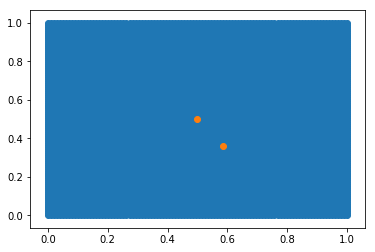

In [6]:
di = 6
theta = disc.dirs[di]
print("theta={}".format(theta))
invgr = inverse_mu_grid(theta, mu_grids[di])
plt.scatter(invgr[:,0], invgr[:,1])
plt.scatter(invpts[:,0], invpts[:,1])
plt.show()

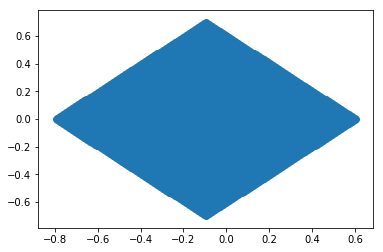

In [7]:
plt.scatter(mu_grids[di,:,0], mu_grids[di,:,1])
plt.show()

In [1]:
fc = 3
model_static = FourierNDModel([np.arange(-fc, fc+1), np.arange(-fc, fc+1)], [1, 1])
# model_static = IdentityModel([1, 1], 2*[p.grid_size_nu])

model = DynamicSuperresModel(model_static, 1, disc.tau, disc.K)
target = model.apply(actual_sources.transpose(), weights)

print("Stage 1: Main objective")
Msys, y = disc.build_main_objective(model_static, target)

NameError: name 'FourierNDModel' is not defined

In [39]:
exactvars = np.hstack((mu.flatten(), nu.flatten()))

In [40]:
mud, nud=np.load("{}{}-fc4/res_{}.npy".format(folder, "disc3-fixrad",i), allow_pickle=True)
resvars = np.hstack((mud.flatten(), nud.flatten()))

In [41]:
np.linalg.norm(Msys@exactvars-y)

3.722764572048947

In [42]:
np.linalg.norm(Msys@resvars-y)

0.20414557833380137

In [8]:
meas_block = Msys.tocsr()[-(3*model_static.meas_size()):,:]
rad_block = Msys.tocsr()[:-(3*model_static.meas_size()),:]
y_rad = y[:-(3*model_static.meas_size())] # should be 0 anyway

In [61]:
print(np.linalg.norm(meas_block@exactvars-target))
print(np.linalg.norm(rad_block@exactvars-y_rad))
print(np.linalg.norm(meas_block@resvars-target))
print(np.linalg.norm(rad_block@resvars-y_rad))

0.23308243917743068
3.7154607568173668
0.1912687811951458
0.07135594224285516


In [74]:
np.argmax(rad_block@exactvars)

7450

In [79]:
np.max(rad_block@resvars),np.argmax(rad_block@resvars)

(0.008080896204492653, 1567)

In [52]:
np.linalg.norm(target-y[-3*model_static.meas_size():])

0.0

In [47]:
model_static.meas_size(), target.shape, y.shape

(162, (486,), (9486,))

In [51]:
y[-3*model_static.meas_size()]

-3.752600550212679

In [50]:
target

array([-3.75260055,  0.13150187, -1.18070661, -3.54295103, -0.84178068,
       -0.26962588, -1.14972638,  2.32904622,  2.956465  ,  1.12545988,
        0.94489449,  1.66771125,  2.71885282,  0.64108673, -0.80817945,
        0.75012993,  1.24531828,  0.43012383, -2.9293894 , -2.12749829,
       -0.47163119,  1.58578069,  1.4659393 ,  0.40609697,  1.46988853,
        2.47576016,  1.86978032, -1.36919311, -1.58047071,  1.48460725,
        0.25830281, -1.08800354,  0.47165   , -1.45388816, -3.13533382,
        0.60630774,  0.08324962,  2.09585432, -0.12123995,  2.19917138,
        5.82902765,  2.19917138, -0.12123995,  2.09585432,  0.08324962,
        0.60630774, -3.13533382, -1.45388816,  0.47165   , -1.08800354,
        0.25830281,  1.48460725, -1.58047071, -1.36919311,  1.86978032,
        2.47576016,  1.46988853,  0.40609697,  1.4659393 ,  1.58578069,
       -0.47163119, -2.12749829, -2.9293894 ,  0.43012383,  1.24531828,
        0.75012993, -0.80817945,  0.64108673,  2.71885282,  1.66

In [14]:
diff=meas_block[:model_static.meas_size(),-30000:-20000]-meas_block[model_static.meas_size():2*model_static.meas_size(),-20000:-10000]

In [18]:
np.linalg.norm(diff.toarray())

1.0510739311071156e-12

In [19]:
diff.toarray()

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.77635684e-15,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  1.38777878e-17,  2.77555756e-17, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  2.77555756e-17,  5.55111512e-17, ...,
         6.82787160e-15,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])